In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os, sys, warnings
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from hmmlearn import hmm

# custom modules
from utilities import *
from helpers import *
# ---------------------------------------------------------
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
# ---------------------------------------------------------
# directories
main_dir = '../'
game_dir = main_dir+'data/'
Data = LoadData(main_dir, game_dir)

#### Load raw event data

In [2]:
# %%time
game_id = '0021500463'
game_data = Data.load_game(game_id)
events_df = pd.DataFrame(game_data['events'])
print('raw events shape:', events_df.shape)
events_df.head(2)

raw events shape: (231, 8)


,end_time_left,home,moments,orig_events,playbyplay,quarter,start_time_left,visitor
0,702.31,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[0],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
1,686.28,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[1],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."


#### Load some meta info

In [3]:
# ddentify defending and offending runs (this is included in process_moments)
court_index = Data.load_csv('./meta_data/court_index.csv')
court_index = dict(zip(court_index.game_id, court_index.court_position))

# home and visitor ids
homeid = events_df.loc[0].home['teamid']
awayid = events_df.loc[0].visitor['teamid']

#### Pre-process 
filter events, subsample frames, add velocity, reorder moments, re-arrange team order
shot clock, filter out event with short moments

In [4]:
# filter out actions except 1: Make, 2: Miss, 4: Rebound, 6:Personal Foul, 7:Violation
use_event = [1, 2, 4, 6, 7]
discard_event = [3, 5, 8, 9, 10, 12, 13, 18]
events = filter_event_type(events_df, discard_event)
print('After filtering events has shape:', events.shape)
# break up sequences at 24secs shot clock point (or irregular case, e.g. out of bound maybe),
# and obtain the game data
subsample_factor = 0
single_game = get_game_data_ra(events, court_index, game_id, event_threshold=10, subsample_factor=subsample_factor)
print('Final number of events:', len(single_game))

After filtering events has shape: (134, 8)
Final number of events: 165


#### Prepare data set for training HMM

In [5]:
n_defend = 5
# length for each moment
event_lengths = np.array([len(i) for i in single_game])
# repeat the event_lengths 5 times in order to match the unstack later on with moments
event_lengths_repeat = np.concatenate([event_lengths for _ in range(n_defend)], axis=0)
# all the moments
all_moments = np.concatenate(single_game, axis=0)
# we only need the first 5 players x,y coordindates
all_moments = all_moments[:, :2*n_defend]
all_moments_ = np.concatenate([all_moments[:, i:i+2] for i in range(0, 2*n_defend, 2)], axis=0)

In [6]:
all_moments_.shape

(105595, 2)

In [7]:
event_lengths_repeat.shape

(825,)

In [8]:
sum(event_lengths_repeat)

105595

In [9]:
len(all_moments)

21119

#### Create HMM model

In [17]:
# Viterbi is set by default as the 'algorithm' optional parameter.
n_comp = 7
n_mix = 1
# model = hmm.GMMHMM(n_components=n_comp, n_mix=n_mix, verbose=True, n_iter=30)
model = hmm.GaussianHMM(n_components=n_comp, verbose=True, n_iter=30)

model.fit(all_moments_, lengths=event_lengths_repeat)

         1     -764502.7440             +nan
         2     -703506.0462      +60996.6978
         3     -647893.5876      +55612.4586
         4     -598938.6998      +48954.8878
         5     -562316.2390      +36622.4608
         6     -555558.9420       +6757.2971
         7     -554627.8538        +931.0882
         8     -554199.4713        +428.3825
         9     -553969.5349        +229.9364
        10     -553867.9373        +101.5976
        11     -553803.5678         +64.3695
        12     -553745.8126         +57.7552
        13     -553707.7803         +38.0323
        14     -553686.7311         +21.0491
        15     -553674.0177         +12.7135
        16     -553663.2158         +10.8019
        17     -553652.2948         +10.9210
        18     -553641.6290         +10.6658
        19     -553632.8429          +8.7860
        20     -553626.7579          +6.0851
        21     -553622.7533          +4.0045
        22     -553619.6241          +3.1292
        23

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=7, n_iter=30, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=True)

In [18]:
# predict the state
state_sequence = model.predict(all_moments_, lengths=event_lengths_repeat)
# unstack s.t. each row contains sequence for each of the players
state_sequence_ = state_sequence.reshape(5, -1).T

In [38]:
state_sequence_[-5:]

array([[3, 3, 3, 3, 0],
       [3, 3, 3, 3, 0],
       [3, 3, 3, 3, 0],
       [3, 3, 3, 3, 0],
       [3, 3, 3, 3, 0]])

In [20]:
len(state_sequence_)

21119

In [21]:
# A problem instance is described by a matrix C, where each C[i,j]
# is the cost of matching vertex i of the first partite set (a “worker”) 
# and vertex j of the second set (a “job”).
# The goal is to find a complete assignment of workers to jobs of minimal cost.
# cost = np.array([[4, 1, 3], [2, 0, 5], [3, 2, 2]])
cost = np.eye(3)
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(cost)
col_ind

cost[row_ind, col_ind].sum()


0.0

[ 8.42968683 34.6203878 ] 
=== [[ 5.36155172  0.        ]
 [ 0.         15.00528833]]
[17.34480379 15.75071298] 
=== [[ 8.80823971  0.        ]
 [ 0.         14.24680989]]
[ 8.80640781 14.22591818] 
=== [[4.98319464 0.        ]
 [0.         9.71145877]]
[29.07907043 22.7290007 ] 
=== [[15.03822209  0.        ]
 [ 0.         53.34879938]]
[ 7.63468207 23.56909519] 
=== [[7.95448415 0.        ]
 [0.         6.54028156]]
[19.06482245 25.89238452] 
=== [[9.70882194 0.        ]
 [0.         6.14031848]]
[18.78386091 35.66260244] 
=== [[14.91404124  0.        ]
 [ 0.         11.7596369 ]]


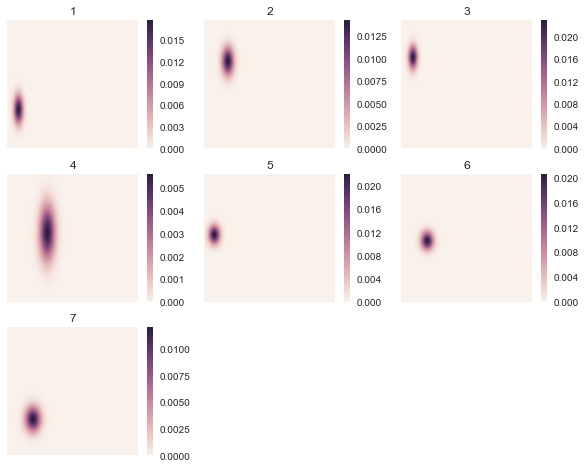

In [36]:
def gaussian_superposition(means_arr, vars_arr, mix_p):
    ''' means_arr: n_mix x feature_dim
        vars_arr: n_mix x feature_dim
    '''
    #Create grid and multivariate normal
    nx = 1000
    ny = 500
    x = np.linspace(0,94,nx)
    y = np.linspace(0,50,ny)

    X, Y = np.meshgrid(x,y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y
    
    def single_gaussian_(mu, var):
        #Parameters to set
        mu_x, mu_y = mu[0], mu[1]
        if mix_p != None:
            var_x, var_y = var[0], var[1]
            rv = multivariate_normal([mu_x, mu_y], [[var_x, 0], [0, var_y]])
        else:
            rv = multivariate_normal([mu_x, mu_y], var)
        return rv.pdf(pos)
    n_mix = means_arr.shape[0]
    if mix_p != None:
        sp = np.sum([single_gaussian_(means_arr[i], vars_arr[i])*mix_p[i] for i in range(n_mix)],axis=0)
    else:
        sp = single_gaussian_(means_arr, vars_arr)
    return X, Y, sp, nx, ny

def plot_3d_gaussian(X,Y,Z):
    %matplotlib notebook
    %matplotlib notebook
    #Make a 3D plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z,cmap='viridis',linewidth=0)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.show()

    
# # plot all the 3ds
# gmms = model.gmms_
# nrows, ncols = 3,3
# # fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,8))
# # figsize=(10,8)
# plt.figure(figsize=(10,8))
# n_state = 0
# for i in range(nrows):
#     for j in range(ncols):
#         if n_state >= n_comp:
#             break
#         ax = plt.subplot(nrows, ncols, n_state+1)
#         X, Y, Z, nx, ny = gaussian_superposition(gmms[n_state].means_, gmms[n_state].covars_, gmms[n_state].weights_)
#         df = pd.DataFrame(Z, index=range(ny), columns=range(nx))
#         sns.heatmap(df, ax=ax, xticklabels=False, yticklabels=False).set_title(str(n_state+1))
#         n_state += 1


# plot all the 3ds
gmms = model
nrows, ncols = 3,3
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,8))
# figsize=(10,8)
plt.figure(figsize=(10,8))
n_state = 0
for i in range(nrows):
    for j in range(ncols):
        if n_state >= n_comp:
            break
        ax = plt.subplot(nrows, ncols, n_state+1)
        X, Y, Z, nx, ny = gaussian_superposition(gmms.means_[n_state], gmms.covars_[n_state], mix_p=None)# gmms.weights_[n_state])
        df = pd.DataFrame(Z, index=range(ny), columns=range(nx))
        sns.heatmap(df, ax=ax, xticklabels=False, yticklabels=False).set_title(str(n_state+1))
        n_state += 1

---

### Next: try using the predefined position as indexing mechanism for the imitation learning

Questions:

  - Is the latent structure learning trained for each individual agent or their sequences are put together?